# Clustering

#### Import the libraries

In [141]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import sys
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
import plotly.graph_objects as go


# Add the root project directory to the Python path
project_root = Path.cwd().parent  # This will get the project root since the notebook is in 'notebooks/'
sys.path.append(str(project_root))
from configs.path_config import CONFIG_DIR, OUTPUT_DIR

#### Load the data

In [142]:
def load_data(path):
    """
    Description: Load data from a csv file containing strain distributions.

    Args:
        path (path object): The path to the csv file.

    Returns:
        df (pd DataFrame): The data loaded from the csv file.
    """
    df = pd.read_csv(path)
    df.isna().sum().sum()

    return df

path = OUTPUT_DIR / 'strain_distributions' / 'N-B_Far_Comp_20091129120000_20210611160000_strain_distribution.csv'
df = load_data(path)


#### Outliers

In [143]:
def remove_outliers(df):
    """
    Description: Remove outliers from the data by calculating the mean of each row and removing rows where the mean deviates
    from the overall mean.

    Args:
        df (pd DataFrame): The data loaded from the csv file.

    Returns:
        df_strain (pd DataFrame): The data cleaned of outliers, without the timestamp column.
        df (pd DataFrame): The data cleaned of outliers, with the timestamp column.
    """
    df_strain = df.drop(columns = 'Timestamp')
    means = df_strain.mean(axis=1)  # Calculate mean for each row

    # Calculate the mean and standard deviation of the row means
    mean_val = means.mean()
    std_val = means.std()

    # Define a threshold for outliers (3 standard deviations from the mean)
    threshold = 1

    # Find outliers: rows where the absolute deviation from the mean is greater than the threshold
    outliers = means[np.abs(means - mean_val) > threshold * std_val]
    print("Outliers:")
    print(outliers)

    df_strain = df_strain.drop(outliers.index) #Removed outliers without timestamp
    df = df.drop(outliers.index) #Removed outliers with timestamp
    print("Number of outliers removed: ", len(outliers))

    return df_strain, df

df_strain, df = remove_outliers(df)

Outliers:
4663    -67798.696825
7798     67861.150794
7799     67861.150794
11783    67893.668254
dtype: float64
Number of outliers removed:  4


#### Perform PCA on the data

In [144]:
def scale_data(df_strain):
    """
    Description: Scale the data using MinMaxScaler.

    Args:
        df_strain (pd DataFrame): The data cleaned of outliers, without the timestamp column.

    Returns:
        df_strain (pd DataFrame): The scaled data.
    """
    # Exclude timestamp in column 0
    df_strain = df_strain.iloc[:, 1:]

    scaler = MinMaxScaler(feature_range=(0, 1))
    # scaler = StandardScaler()
    df_strain = pd.DataFrame(scaler.fit_transform(df_strain.T).T, columns=df_strain.columns)

    return df_strain

df_strain = scale_data(df_strain)

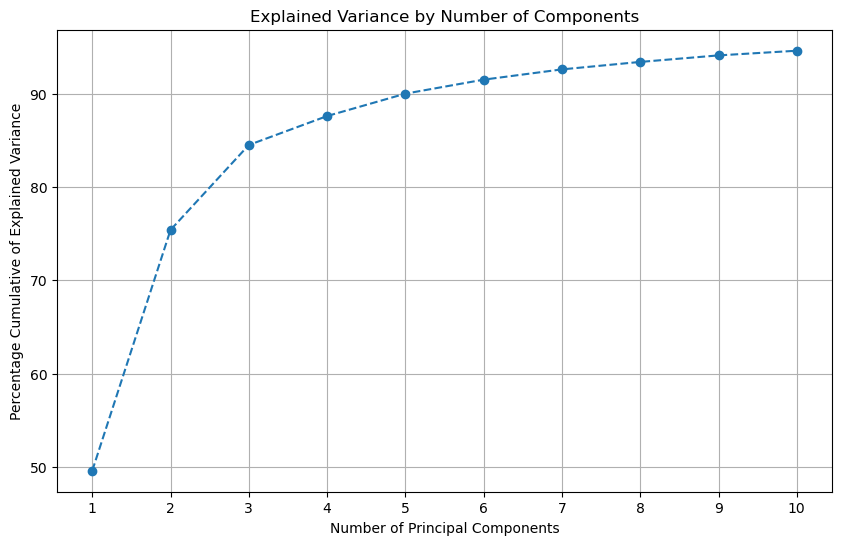

In [145]:
def explain_variance(df_strain) -> None:  
    """
    Descripition: Plots the explained variance by number of components for PCA.

    Args:
        df_strain (pd DataFrame): The data.

    Returns:
        None    
    """
    # Fit PCA on the entire strain data (matrix-wise)
    # Set the number of components directly (e.g., 5 components)
    pca = PCA(n_components=10)
    pca.fit(df_strain)
    # 
    # Get the explained variance ratio
    per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)

    # Plot the cumulative explained variance
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(per_var) + 1), per_var.cumsum(), marker="o", linestyle="--")
    plt.grid()
    plt.ylabel("Percentage Cumulative of Explained Variance")
    plt.xlabel("Number of Principal Components")
    plt.xticks(range(1, len(per_var) + 1, 1))
    plt.title("Explained Variance by Number of Components")
    plt.show()

explain_variance(df_strain)

In [146]:
def do_pca(n_components, df_strain):
    """
    Description: Perform PCA on the data.

    Args:
        n_components (int): The number of principal components to keep.
        df_strain (pd DataFrame): The data.

    Returns:
        df_pca (pd DataFrame): The principal components for each timestamp.
        normalized_pca_components (np array) : The normalized principal components.
    """
    # Perform PCA
    pca = PCA(n_components=n_components)

    # Fit PCA on the entire strain data (matrix-wise)
    pca.fit(df_strain)

    # Apply PCA to the entire strain data (matrix-wise)
    pca_results = pca.transform(df_strain)

    # Normalize the results
    normalized_pca_components = StandardScaler().fit_transform(pca_results)

    # Convert results into a DataFrame
    df_pca = pd.DataFrame(normalized_pca_components, columns=[f'PC{i+1}' for i in range(n_components)])

    # Add timestamps back
    df_pca.insert(0, 'Timestamp', df['Timestamp'].values)

    return normalized_pca_components, df_pca

n_components = 8
normalized_pca_components, df_pca = do_pca(n_components, df_strain)

#### KMeans Clustering

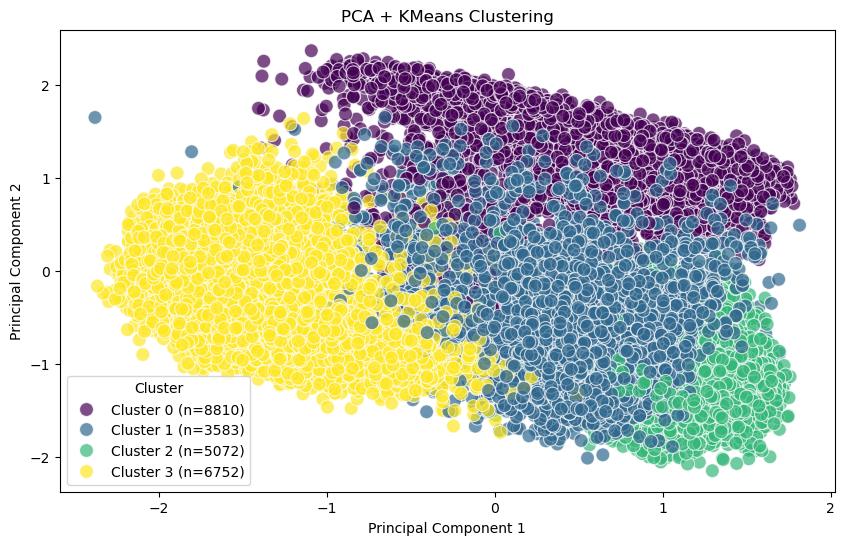

In [159]:
def kmeans_clustering(normalized_pca_components, df, n_clusters):
    """
    Description: Perform K-Means clustering on the normalized PCA components and visualize the clusters.
    Args:
        normalized_pca_components (nparray): The PCA components normalized using StandardScaler.
        df (pd DataFrame): The original DataFrame including the timestamps.
        n_clusters (int): The number of clusters to create.

    Returns:
        data_with_KMeans (pd DataFrame): The original DataFrame including the timestamps with the addition of the cluster labels.
    """
   
    kmeans = KMeans(n_clusters, random_state=42)
    clusters = kmeans.fit_predict(normalized_pca_components)

    # Add cluster labels to your original data (without overwriting)
    data_with_KMeans = df.copy()  # Make a copy to preserve the original DataFrame

    # Insert the clusters as the second column (at index 1)
    data_with_KMeans.insert(1, 'Cluster', clusters)

    # Count the number of data points assigned to each cluster
    cluster_counts = {i: sum(clusters == i) for i in range(n_clusters)}

    # Plot the clusters
    plt.figure(figsize=(10, 6))
    scatter = sns.scatterplot(x=normalized_pca_components[:, 0], y=normalized_pca_components[:, 1], hue=clusters, palette="viridis", s=100, alpha=0.7)

    # Create custom labels for the legend with the cluster counts
    legend_labels = [f'Cluster {i} (n={cluster_counts[i]})' for i in range(n_clusters)]
    handles, _ = scatter.get_legend_handles_labels()

    # Set the custom labels in the legend
    plt.legend(handles=handles, labels=legend_labels, title='Cluster')

    # Label the axes
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title("PCA + KMeans Clustering")

    # Show the plot
    plt.show()

    # Show the updated DataFrame with the Cluster column as the second column
    return data_with_KMeans

n_components = 8
normalized_pca_components, df_pca = do_pca(n_components, df_strain)

n_clusters = 4
data_with_KMeans = kmeans_clustering(normalized_pca_components, df, n_clusters)

#### Plot the cluster assignment over time

In [148]:
def plot_clusters_over_time(data_with_clusters, method) -> None:
    """
    Description: Plot the assignment to clusters over time with any clustering method.

    Args:
        data_with_KMeans (pd DataFrame): The original DataFrame including the timestamps with the addition of the cluster labels.
        metod (str): The clustering method used (e.g., 'KMeans', 'GMM', 'DBSCAN'). This will be used in the title.

    Returns:
        None
    """
    # Assuming 'Timestamp' is a column with string dates, we convert it to datetime format.
    data_with_KMeans['Timestamp'] = pd.to_datetime(df['Timestamp'])

    # Create the Plotly figure
    fig = go.Figure()

    # Add a scatter plot (you can choose 'line' or 'scatter' depending on the style you want)
    fig.add_trace(go.Scatter(x=data_with_KMeans['Timestamp'], 
                            y=data_with_KMeans['Cluster'], 
                            mode='markers+lines',  # markers and lines
                            marker=dict(size=8, 
                                        color=data_with_KMeans['Cluster'],  # Color by cluster value
                                        colorscale='Viridis',  # You can change the colorscale here
                                        colorbar=dict(title='Cluster')),  # Add a color bar to show the scale
                            line=dict(width=1, color='grey')))  # Customizing line color and width

    # Update layout with title and labels
    fig.update_layout(
        title=f'Assignment to Clusters Over Time with {method} Clustering',
        xaxis_title='Time',
        yaxis_title='Cluster',
        xaxis_tickangle=-45,  # Rotate x-axis labels for better readability
        yaxis=dict(tickmode='linear', tick0=0, dtick=1)  # Set y-tick step size to 1
    )

    # Show the figure
    fig.show()

plot_clusters_over_time(data_with_KMeans, 'KMeans')

#### Plot the mean distribution for each cluster and the standard deviation

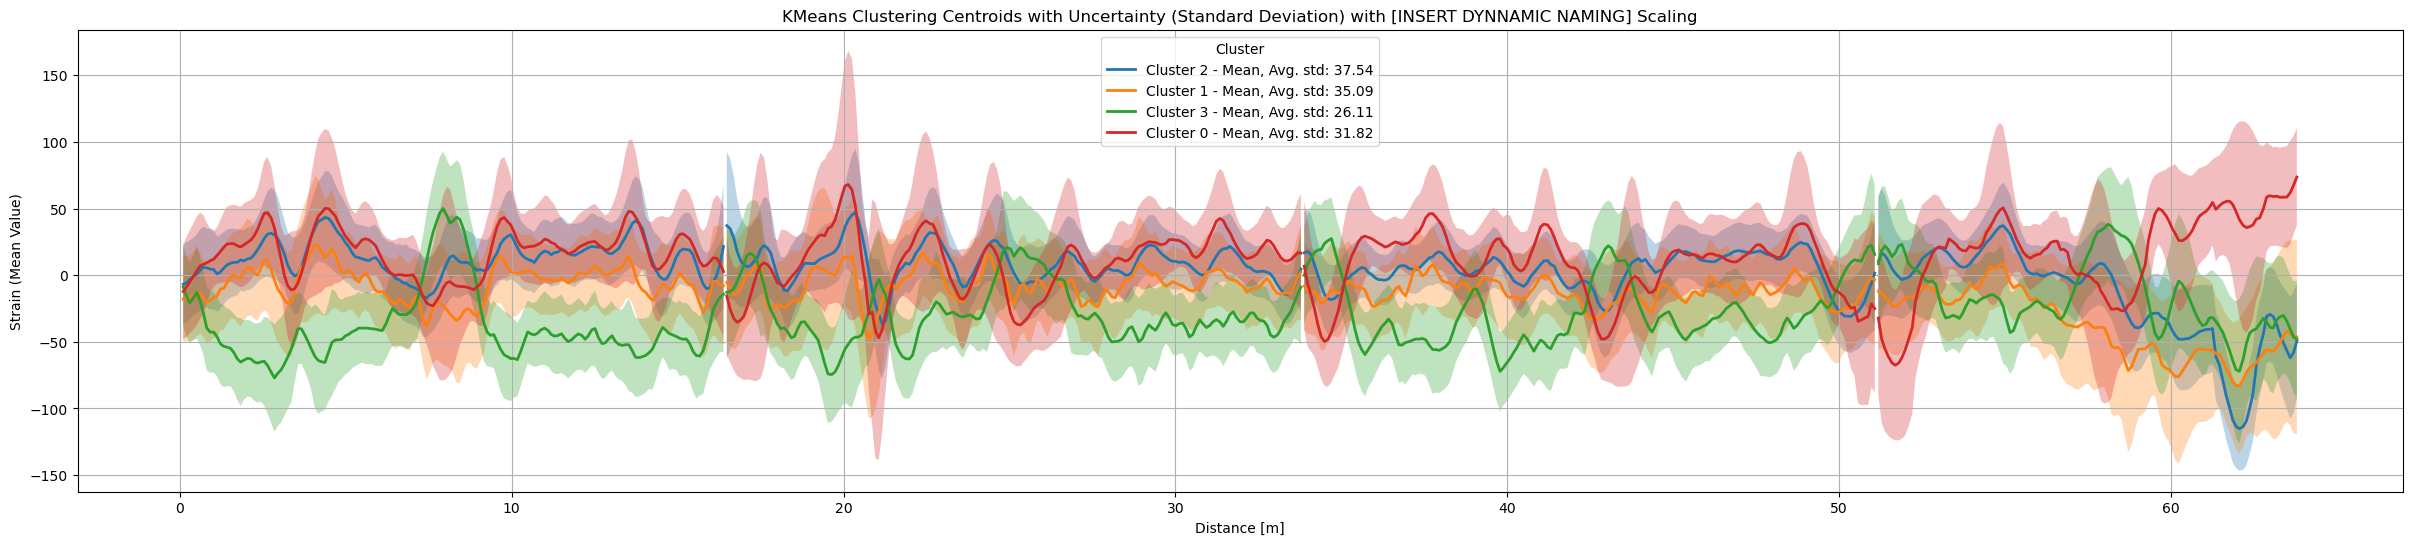

In [149]:
def plot_cluster_mean_and_std(data_with_clusters, clusters_to_keep, method) -> None:
    """
    Description: Plot the mean strain values for each cluster with uncertainty (standard deviation).

    Args:
        data_with_clusters (pd DataFrame): The original DataFrame including the timestamps with the addition of the cluster labels. (e.g., data_with_KMeans)
        clusters_to_keep (list): List of which clusters to keep (e.g., [0, 1, 2]). Use ['all'] to keep all clusters.
        method (str): The clustering method used (e.g., 'KMeans', 'GMM', 'DBSCAN'). This will be used in the title.

    Returns:
        None
    """
    # Check if the user wants to keep all clusters
    if clusters_to_keep == ['all']:
        clusters_to_keep = data_with_clusters['Cluster'].unique()  # Use the correct attribute to get unique cluster indices

    # Group the data by Cluster and compute the mean strain values for each cluster
    df_cluster_mean = data_with_clusters.drop(columns='Timestamp').groupby('Cluster').mean()

    # Convert column names (assumed to be distances along the beam) to numeric values
    x_values = pd.to_numeric(df_cluster_mean.columns, errors='coerce')  # Convert column names to numeric

    # Filter the DataFrame to keep only the selected rows
    df_cluster = df_cluster_mean.loc[clusters_to_keep]  # Use .loc for row selection

    # Step 1: Calculate the standard deviation of strain values for each cluster
    df_cluster_std = data_with_clusters.drop(columns='Timestamp').groupby('Cluster').std()

    average_std = df_cluster_std.mean(axis=1)

    # Step 2: Plot the cluster centroids with uncertainty (shaded region)
    plt.figure(figsize=(30, 6))

    # Loop over clusters and plot their mean strain and uncertainty (standard deviation)
    for i, cluster in enumerate(df_cluster.index):
        # Plot the mean strain distribution for the current cluster
        plt.plot(x_values, df_cluster.loc[cluster], label=f'Cluster {cluster} - Mean, Avg. std: {average_std[i]:.2f}', linewidth=2)
        
        # Plot the uncertainty region (standard deviation) around the mean
        plt.fill_between(x_values, 
                         df_cluster.loc[cluster] - df_cluster_std.loc[cluster], 
                         df_cluster.loc[cluster] + df_cluster_std.loc[cluster], 
                         alpha=0.3)  # Shaded region for uncertainty

    # Customizing the plot
    plt.xlabel('Distance [m]')
    plt.ylabel('Strain (Mean Value)')
    plt.title(f'{method} Clustering Centroids with Uncertainty (Standard Deviation) with [INSERT DYNNAMIC NAMING] Scaling')
    plt.legend(title='Cluster')
    plt.grid(True)
    plt.show()

clusters_to_keep = ['all'] # 'all' or a list of cluster indices
plot_cluster_mean_and_std(data_with_KMeans, clusters_to_keep, 'KMeans')

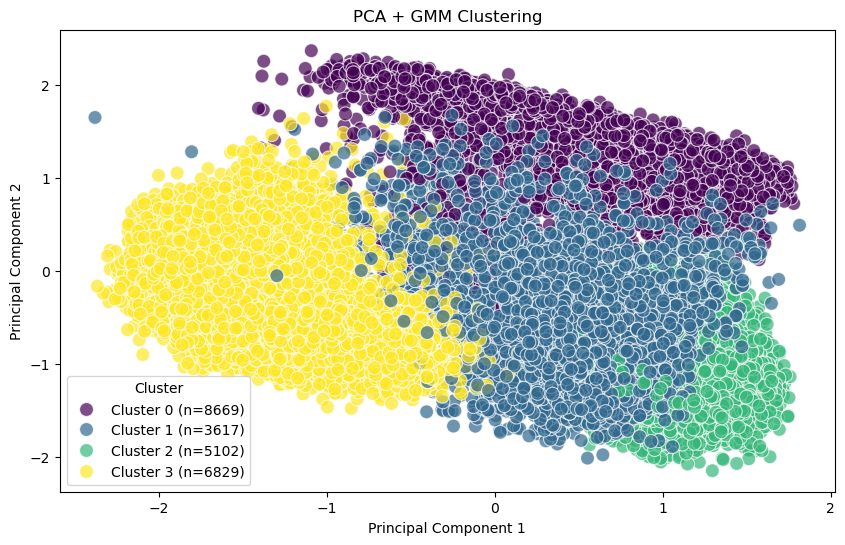

In [158]:
def gmm_clustering(normalized_pca_components, df, n_clusters):
    """
    Description: Perform GMM clustering on the normalized PCA components and visualize the clusters.
    Args:
        normalized_pca_components (nparray): The PCA components normalized using StandardScaler.
        df (pd DataFrame): The original DataFrame including the timestamps.
        n_clusters (int): The number of clusters to create.

    Returns:
        data_with_gmm (pd DataFrame): The original DataFrame including the timestamps with the addition of the cluster labels.
    """
   
    kmeans = GaussianMixture(n_clusters, random_state=42)
    clusters = kmeans.fit_predict(normalized_pca_components)

    # Add cluster labels to your original data (without overwriting)
    data_with_gmm = df.copy()  # Make a copy to preserve the original DataFrame

    # Insert the clusters as the second column (at index 1)
    data_with_gmm.insert(1, 'Cluster', clusters)

    # Count the number of data points assigned to each cluster
    cluster_counts = {i: sum(clusters == i) for i in range(n_clusters)}

    # Plot the clusters
    plt.figure(figsize=(10, 6))
    scatter = sns.scatterplot(x=normalized_pca_components[:, 0], y=normalized_pca_components[:, 1], hue=clusters, palette="viridis", s=100, alpha=0.7)

    # Create custom labels for the legend with the cluster counts
    legend_labels = [f'Cluster {i} (n={cluster_counts[i]})' for i in range(n_clusters)]
    handles, _ = scatter.get_legend_handles_labels()

    # Set the custom labels in the legend
    plt.legend(handles=handles, labels=legend_labels, title='Cluster')

    # Label the axes
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title("PCA + GMM Clustering")

    # Show the plot
    plt.show()

    # Show the updated DataFrame with the Cluster column as the second column
    return data_with_gmm

n_components = 8
normalized_pca_components, df_pca = do_pca(n_components, df_strain)

n_clusters = 4
data_with_gmm = gmm_clustering(normalized_pca_components, df, n_clusters)

In [151]:
plot_clusters_over_time(data_with_gmm, 'GMM')

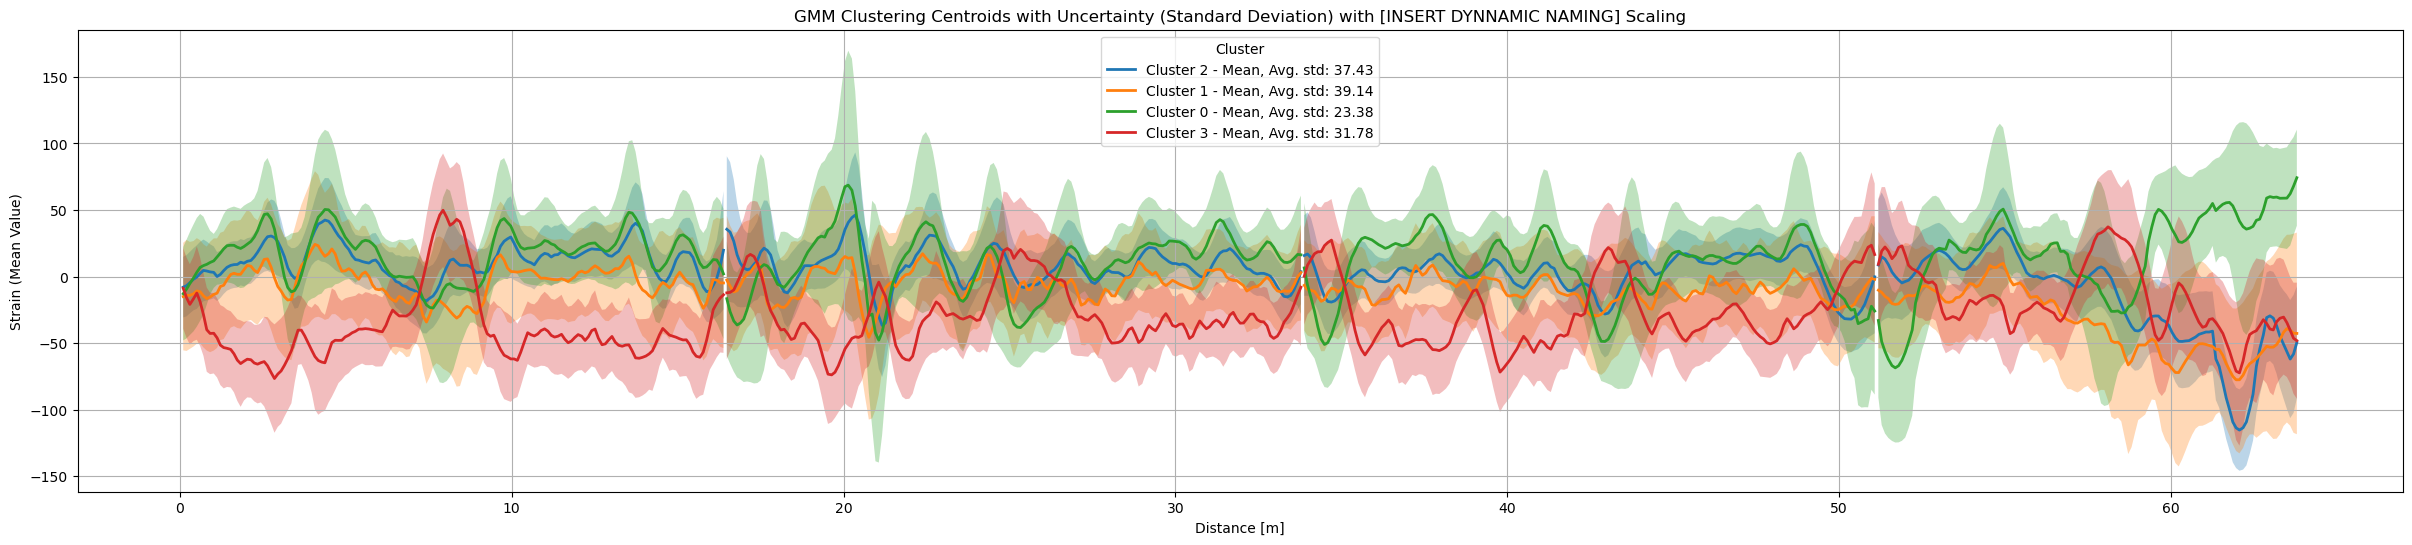

In [152]:
clusters_to_keep = ['all'] # 'all' or a list of cluster indices
plot_cluster_mean_and_std(data_with_gmm, clusters_to_keep, 'GMM')

C:\Users\hpl886\AppData\Local\Temp\ipykernel_17808\1044592450.py:35: UserWarning:

Mismatched number of handles and labels: len(handles) = 5 len(labels) = 4



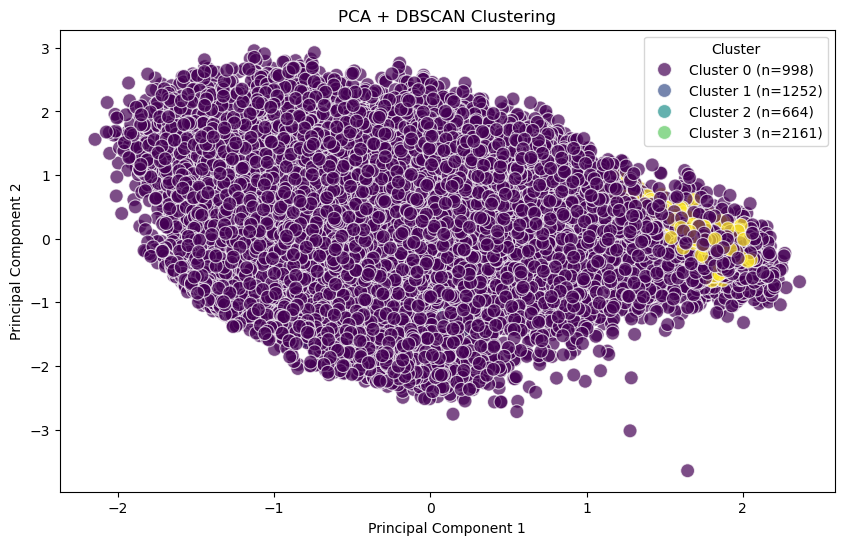

In [173]:
def dbscan_clustering(normalized_pca_components, df, eps, min_samples):
    """
    Description: Perform DBSCAN clustering on the normalized PCA components and visualize the clusters.
    Args:
        normalized_pca_components (nparray): The PCA components normalized using StandardScaler.
        df (pd DataFrame): The original DataFrame including the timestamps.
        n_clusters (int): The number of clusters to create.

    Returns:
        data_with_dbscan (pd DataFrame): The original DataFrame including the timestamps with the addition of the cluster labels.
    """
   
    # Fit the DBSCAN model
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(normalized_pca_components)

    # Add cluster labels to your original data (without overwriting)
    data_with_dbscan = df.copy()  # Make a copy to preserve the original DataFrame

    # Insert the clusters as the second column (at index 1)
    data_with_dbscan.insert(1, 'Cluster', clusters)

    # Count the number of data points assigned to each cluster
    cluster_counts = {i: sum(clusters == i) for i in range(n_clusters)}

    # Plot the clusters
    plt.figure(figsize=(10, 6))
    scatter = sns.scatterplot(x=normalized_pca_components[:, 1], y=normalized_pca_components[:, 2], hue=clusters, palette="viridis", s=100, alpha=0.7)

    # Create custom labels for the legend with the cluster counts
    legend_labels = [f'Cluster {i} (n={cluster_counts[i]})' for i in range(n_clusters)]
    handles, _ = scatter.get_legend_handles_labels()

    # Set the custom labels in the legend
    plt.legend(handles=handles, labels=legend_labels, title='Cluster')

    # Label the axes
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title("PCA + DBSCAN Clustering")

    # Show the plot
    plt.show()

    # Show the updated DataFrame with the Cluster column as the second column
    return data_with_dbscan

n_components = 8
normalized_pca_components, df_pca = do_pca(n_components, df_strain)

data_with_dbscan = dbscan_clustering(normalized_pca_components, df, eps=0.5, min_samples=50)

In [154]:
# clusters_to_keep = ['all'] # 'all' or a list of cluster indices
# plot_cluster_mean_and_std(data_with_dbscan, clusters_to_keep, 'DBSCAN')

In [155]:
# Assuming 'Timestamp' is a column with string dates, we convert it to datetime format.
data_with_dbscan['Timestamp'] = pd.to_datetime(data_with_dbscan['Timestamp'])

# Create the Plotly figure
fig = go.Figure()

# Add a scatter plot (you can choose 'line' or 'scatter' depending on the style you want)
fig.add_trace(go.Scatter(x=data_with_dbscan['Timestamp'], 
                         y=data_with_dbscan['Cluster'], 
                         mode='markers+lines',  # markers and lines
                         marker=dict(size=8, 
                                     color=data_with_dbscan['Cluster'],  # Color by cluster value
                                     colorscale='Viridis',  # You can change the colorscale here
                                     colorbar=dict(title='Cluster')),  # Add a color bar to show the scale
                         line=dict(width=1, color='grey')))  # Customizing line color and width

# Update layout with title and labels
fig.update_layout(
    title='Assignment to Clusters Over Time with DBSCAN Clustering',
    xaxis_title='Time',
    yaxis_title='Cluster',
    xaxis_tickangle=-45,  # Rotate x-axis labels for better readability
    yaxis=dict(tickmode='linear', tick0=0, dtick=1)  # Set y-tick step size to 1
)

# Show the figure
fig.show()

#### Number of clusters

In [156]:
def evaluate_clusters(normalized_pca_components, n_clusters) -> None:
    """
    Description: Evaluate different clustering algorithms (KMeans, GMM, DBSCAN) using Silhouette Score and Davies-Bouldin Index.

    Args:
        normalized_pca_components (nparray): The PCA components normalized using StandardScaler.
        n_clusters (int): The maximum number of clusters to evaluate.

    Returns:
        None    
    """

    # Initialize lists to store inertia and Davies-Bouldin index for KMeans
    silhouette_kmeans = []  # Sum of squared distances of samples to their closest cluster center
    db_index_kmeans = []  # Davies-Bouldin Index

    # Initialize lists to store inertia and Davies-Bouldin index for GMM
    silhouette_gmm = []  
    db_index_gmm = []  

    # Initialize lists to store inertia and Davies-Bouldin index for DBSCAN
    silhouette_dbscan = []  
    db_index_dbscan = []  
 

    # Loop over different number of clusters
    for n in range(2, n_clusters + 1):

        # KMeans Clustering
        kmeans = KMeans(n_clusters=n, random_state=42)
        kmeans_labels = kmeans.fit_predict(normalized_pca_components)

        # Davies-Bouldin Index for KMeans
        db_score_kmeans = davies_bouldin_score(normalized_pca_components, kmeans_labels)
        db_index_kmeans.append(db_score_kmeans)
        # Silhouette Score for KMeans
        silhouette_kmeans.append(silhouette_score(normalized_pca_components, kmeans_labels))
        
        print(f"K-Means - Number of clusters: {n}, Davies-Bouldin Index: {db_score_kmeans}, Silhouette Score: {silhouette_score(normalized_pca_components, kmeans_labels)}")

        # GMM Clustering
        gmm = GaussianMixture(n_components=n, random_state=42)
        gmm_labels = gmm.fit_predict(normalized_pca_components)

        # Davies-Bouldin Index for GMM
        db_score_gmm = davies_bouldin_score(normalized_pca_components, gmm_labels)
        db_index_gmm.append(db_score_gmm)
        # Silhouette Score for GMM
        silhouette_gmm.append(silhouette_score(normalized_pca_components, gmm_labels))
        
        print(f"GMM - Number of components: {n}, Davies-Bouldin Index: {db_score_gmm}, Silhouette Score: {silhouette_score(normalized_pca_components, gmm_labels)}")

        # DBSCAN Clustering (DBSCAN does not require number of clusters, so we use eps and min_samples)
        dbscan = DBSCAN(eps=0.5, min_samples=5)
        dbscan_labels = dbscan.fit_predict(normalized_pca_components)

        # Davies-Bouldin Index for DBSCAN (ignoring -1 labels as noise points)
        db_score_dbscan = davies_bouldin_score(normalized_pca_components[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1])
        db_index_dbscan.append(db_score_dbscan)
        
        # Silhouette Score for DBSCAN (ignoring -1 labels as noise points)
        silhouette_dbscan.append(silhouette_score(normalized_pca_components[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1]))
        
        print(f"DBSCAN - Davies-Bouldin Index: {db_score_dbscan}, Silhouette Score: {silhouette_score(normalized_pca_components[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1])}")

    # Plot the Elbow graph and Davies-Bouldin Index in subplots
    fig, axes = plt.subplots(2, 1, figsize=(10, 12))

    # Elbow Method Plot (Inertia)
    axes[0].plot(range(2, n_clusters+1), silhouette_kmeans, marker='o')
    axes[0].plot(range(2, n_clusters+1), silhouette_gmm, marker='o')
    # axes[0].plot(range(2, n_clusters+1), silhouette_dbscan, marker='o')
    axes[0].set_title("Silhouette Score for Different Number of Clusters")
    axes[0].set_xlabel("Number of Clusters")
    axes[0].set_ylabel("Silhouette Score")
    axes[0].legend(['KMeans', 'GMM', 'DBSCAN'])

    # Davies-Bouldin Index Plot
    axes[1].plot(range(2, n_clusters+1), db_index_kmeans, marker='o')
    axes[1].plot(range(2, n_clusters+1), db_index_gmm, marker='o')
    # axes[1].plot(range(2, n_clusters+1), db_index_dbscan, marker='o')
    axes[1].set_title("Davies-Bouldin Index for Different Number of Clusters")
    axes[1].set_xlabel("Number of Clusters")
    axes[1].set_ylabel("Davies-Bouldin Index")
    axes[1].legend(['KMeans', 'GMM','DBSCAN'])

    plt.tight_layout()

    plt.show()

# Call the function with the normalized PCA components
n_components = 5
normalized_pca_components, df_pca = do_pca(n_components, normalized_pca_components)

n_clusters = 10
# evaluate_clusters(normalized_pca_components, n_clusters)